In [1]:
import seaborn as sns
import os
import networkx as nx
from pprint import pprint
import pandas as pd
import numpy as np
import random
import math as m
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
from grave import plot_network
basedir = '../results'

def giant_component(g: nx.Graph) -> nx.Graph:
    return nx.subgraph(g, max(nx.connected_components(g), key=len))


/tmp/ipykernel_410453/340818752.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


In [98]:
##Read all the graphs
graphs = []
for d in os.listdir(basedir):
    for f in os.listdir(f'{basedir}/{d}'):
        g = giant_component(nx.read_graphml(f'{basedir}/{d}/{f}'))
        graphs.append((d,f,g))


Robustness Analysis

In [42]:
def random_robustness_gc(G, steps=10, runs=1):
    ##Random robustness measuring the giant component
    y = np.zeros(shape=(steps, runs+1))
    # BCC = G.subgraph(max(nx.connected_components(G), key=len))+
    xs = np.linspace(0, 1, steps, endpoint=False)
    y[:,0] = xs
    to_rem = (xs*len(G)).astype(int)
    for j in range(runs):
        for i, x in enumerate(to_rem):
            G_copy = G.copy()
            for n in random.sample(list(G_copy.nodes()), x):
                G_copy.remove_node(n)
            try:
                GC = max(nx.connected_components(G_copy), key=len)
                metric = len(GC)/len(G_copy)
            except ValueError:
                metric = 0/len(G_copy)
            y[i, j+1] = metric
            #print(f"Removed {int(xs)} nodes, G={len(G_copy)}, {len(GC)}")
        del G_copy
    return y

def random_robustness_gwcc(G, steps=10, runs=1):
    ##Random robustnes measuring the size of the components reachable by at least 1 GW
    y = np.zeros(shape=(steps, runs+1))
    # BCC = G.subgraph(max(nx.connected_components(G), key=len))+
    xs = np.linspace(0, 1, steps, endpoint=False)
    y[:,0] = xs
    to_rem = (xs*len(G)).astype(int)
    gws = [n for n in G if G.nodes[n].get('type') == 'gateway']
    for j in range(runs):
        for i, x in enumerate(to_rem):
            G_copy = G.copy()
            for n in random.sample(list(G_copy.nodes()), x):
                G_copy.remove_node(n)
            try:
                reachable_nodes = 0
                ccs = nx.connected_components(G_copy)
                for cc in ccs:
                    for gw in gws:
                        if gw in cc:
                            reachable_nodes+=len(cc)
                            break
                metric = reachable_nodes/len(G_copy)
            except ValueError:
                metric = 0/len(G_copy)
            y[i, j+1] = metric
            #print(f"Removed {int(xs)} nodes, G={len(G_copy)}, {len(GC)}")
        del G_copy
    return y


In [43]:
robustness = []
for (d,f,g) in graphs:
    area, lamb, radius, x, y = d.split('_')
    time, random_seed, topo_strategy, gw_strategy, runid = f.split('.')[0].split('_')
    rob = random_robustness_gwcc(g)
    for r in rob:
        robust = {}
        robust['fraction'] = r[0]
        robust['value'] = r[1]
        robust['lamb'] = lamb
        robust['topo_strategy'] = topo_strategy
        robust['time'] = time
        robust['run'] = runid
        robust['area'] = area
        robustness.append(robust)
rdf = pd.DataFrame(robustness)


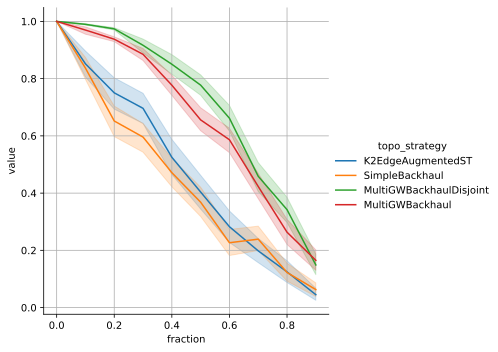

In [112]:
sns.relplot(data=rdf[(rdf.topo_strategy != 'VisGraphMultiGW') & (rdf.topo_strategy != 'VisGraph')], x='fraction', y='value', hue='topo_strategy', kind='line')
plt.grid()

Graph plotting

In [64]:
df[(df.area=='firenze') &( df.nodes==93)& (df.run=='0')]

,run,nodes,edges,diameter,area,lamb,topo_strategy,gw_strategy,time,seed
1,0,93,278,6,firenze,60,VisGraph,BetweennessGW,16474340078,68
71,0,93,155,6,firenze,60,K2EdgeAugmentedST,BetweennessGW,16474340060,68
89,0,93,165,6,firenze,60,MultiGWBackhaulDisjoint,BetweennessGW,16474340074,68
124,0,93,92,6,firenze,60,SimpleBackhaul,BetweennessGW,16474340066,68
293,0,93,133,6,firenze,60,MultiGWBackhaul,BetweennessGW,16474340070,68


Analysis on more simple metrics

In [115]:
def average_path_length(graph: nx.Graph):
    gws = [n for n in graph if 'type' in graph.nodes[n] and graph.nodes[n]['type'] == 'gateway']
    plenghts = nx.multi_source_dijkstra_path_length(g, gws)
    lengths = np.array(list(plenghts.values()))

    return lengths.mean(), lengths.max()
    
    

In [116]:
data = []
for (d,f,g) in graphs:
    measures = {}
    area, lamb, radius, x, y = d.split('_')
    time, random_seed, topo_strategy, gw_strategy, runid = f.split('.')[0].split('_')
    measures['run'] = runid
    measures['nodes'] = len(g)
    measures['edges'] = len(g.edges())    
    measures['avg_pathl'], measures['max_pathl'] = average_path_length(g)
    measures['area'] = area
    measures['lamb'] = lamb
    measures['topo_strategy'] = topo_strategy
    measures['gw_strategy'] = gw_strategy
    measures['time'] = time
    measures['seed'] = random_seed
    data.append(measures)
        
df = pd.DataFrame(data)


In [119]:
df

,run,nodes,edges,avg_pathl,max_pathl,area,lamb,topo_strategy,gw_strategy,time,seed
0,4,87,167,1.482759,3,firenze,60,K2EdgeAugmentedST,BetweennessGW,16474462285,38
1,4,93,92,1.688172,3,firenze,60,SimpleBackhaul,BetweennessGW,16474462686,38
2,6,90,233,1.311111,3,firenze,60,MultiGWBackhaulDisjoint,BetweennessGW,16474462301,38
3,2,95,191,1.357895,3,firenze,60,MultiGWBackhaul,BetweennessGW,16474462785,38
4,6,103,681,1.223301,2,firenze,60,VisGraphMultiGW,BetweennessGW,16474462595,38
...,...,...,...,...,...,...,...,...,...,...,...
1255,6,91,200,1.274725,2,napoli,60,MultiGWBackhaul,BetweennessGW,16474468642,21
1256,6,93,176,1.397849,3,napoli,60,MultiGWBackhaul,BetweennessGW,16474468492,21
1257,3,102,101,1.637255,3,napoli,60,SimpleBackhaul,BetweennessGW,16474468693,21
1258,5,98,788,1.326531,3,napoli,60,VisGraphMultiGW,BetweennessGW,16474469155,21


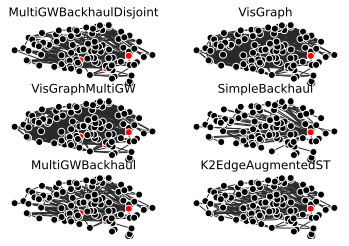

In [120]:
def layout(graph):
    pos_x = nx.get_node_attributes(graph, 'x')
    pos_y = nx.get_node_attributes(graph, 'y')
    return {n: (pos_x[n], pos_y[n]) for n in pos_x}

def nodest(node_attribute):
    if 'type' in node_attribute:
        return {'color':  'red'}
    else:
        return {'color': 'black'}
#print(graphs[0].nodes(data=True))
#print(df)

for idx,id in enumerate(df[(df.nodes==102) & (df.area=='napoli')& (df.run=='0') ].index.values):
    d,f,g=graphs[id]
    time, random_seed, topo_strategy, gw_strategy, runid = f.split('.')[0].split('_')
    ax = plt.subplot(3,2,idx+1)
    ax.set_title(topo_strategy)
    plot_network(g, layout=layout, node_style=nodest)


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'K2EdgeAugmentedST'),
  Text(1, 0, 'SimpleBackhaul'),
  Text(2, 0, 'MultiGWBackhaulDisjoint'),
  Text(3, 0, 'MultiGWBackhaul'),
  Text(4, 0, 'VisGraphMultiGW'),
  Text(5, 0, 'VisGraph')])

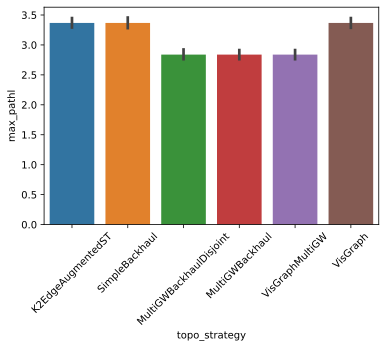

In [118]:
sns.barplot(data=df, x='topo_strategy', y='max_pathl')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'K2EdgeAugmentedST'),
  Text(1, 0, 'SimpleBackhaul'),
  Text(2, 0, 'MultiGWBackhaulDisjoint'),
  Text(3, 0, 'MultiGWBackhaul'),
  Text(4, 0, 'VisGraphMultiGW'),
  Text(5, 0, 'VisGraph')])

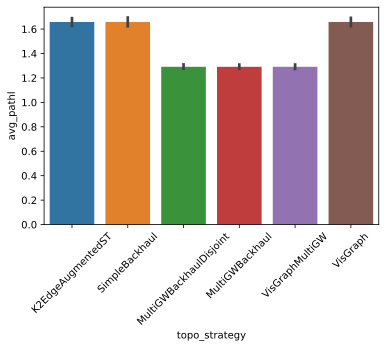

In [122]:
sns.barplot(data=df, x='topo_strategy', y='avg_pathl')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'K2EdgeAugmentedST'),
  Text(1, 0, 'SimpleBackhaul'),
  Text(2, 0, 'MultiGWBackhaulDisjoint'),
  Text(3, 0, 'MultiGWBackhaul'),
  Text(4, 0, 'VisGraphMultiGW'),
  Text(5, 0, 'VisGraph')])

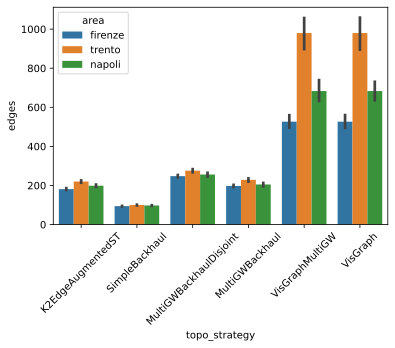

In [116]:
sns.barplot(data=df, x='topo_strategy', y='edges', hue='area')
plt.xticks(rotation=45)


Cost model for the network

Simple model with a PtP link (2 devices) for each edge, whose capacity depends on the number of links passing trough it

802.11ay mmWave:
2.16 Ghz -> 3850Mbps (2Gbps dw)
8 potential channels -> 16Gbps  (160 customers at 100mbps)

2km -> 200€x2

4.32 Ghz -> 6Gbps (3Gbps dw)
2km -> 800€
4km -> 2000€

In [128]:
## FIX MGB for each node
mgb = 100   #100mbps achievable bw
cost100m = 200
bw_per_channel = 2000 #mbps
max_channels = 8
capex_costs = {
    'gateway_deploy': 10000, #cost to deploy trellis + works + permits
    'gateway_router': 5000, #Imaginary cool router
    'fiber_deploy': 30000, #assume only 1km is needed
    'relay_router': 2000, #EdgeRouter Infinity
    'relay_deploy':  2000, # cost for trellis +  works 
    'leaf_deploy': 1000, #cost for roof installation
    '2gbps_link_long': 2000, #4km max, 7channels 900mbps at 5ghz
    '2gbps_link_short': 800, #2km max, 7channels 900mbps at 5ghz
}
## Calculate shortest path towards closest GW.


def calc_cost_network(g):
    for e in g.edges():
        g.edges[e]['paths'] = 0
    
    ## For each edge where a SP pass accumulate a value (n of link insisting)
    gws = [n for n in g if 'type' in g.nodes[n] and g.nodes[n]['type'] == 'gateway']
    paths = nx.multi_source_dijkstra_path(g, gws)
    for k,path in paths.items():
        for i in range(len(path)-1):
            g.edges[path[i], path[i+1]]['paths'] += 1
                 
    ## Multiplicate the value by the BW needed for each node
    ## Calculate the cost of each edge
    for e in g.edges():
        if(g.edges[e]['paths'] == 0):
            ## For redundancy link assume a single path
            g.edges[e]['paths'] = 1
            g.edges[e]['redundant'] = 1
        else:
            g.edges[e]['redundant'] = 0
        g.edges[e]['bw'] = mgb * g.edges[e]['paths']
        g.edges[e]['channels'] = m.ceil(g.edges[e]['bw'] / bw_per_channel)
        if(g.edges[e]['channels'] > max_channels):
            raise(Exception('More than 8 channels (16gbps) on a single link'))
        g.edges[e]['radio_cost'] = g.edges[e]['channels'] * capex_costs['2gbps_link_short']
    
    for n in g.nodes():
        if g.nodes[n].get('type') == 'gateway':
            g.nodes[n]['router_cost'] = capex_costs['gateway_router'] 
            g.nodes[n]['fiber_cost' ] = capex_costs['fiber_deploy']
            g.nodes[n]['deploy'] = capex_costs['gateway_deploy']
        else:
            g.nodes[n]['fiber_cost' ] = g.nodes[n]['deploy'] = 0
            if g.degree()[n] == 1:
                #leaf node, no router
                g.nodes[n]['deploy'] = capex_costs['leaf_deploy']
                g.nodes[n]['router_cost'] = 0
            elif g.degree()[n] <= 8:
                #relay node, needs router
                g.nodes[n]['router_cost'] = capex_costs['relay_router']
                g.nodes[n]['deploy'] = capex_costs['relay_deploy']
            else:
                g.nodes[n]['deploy'] = capex_costs['relay_deploy']
                g.nodes[n]['router_cost'] = capex_costs['relay_router'] * m.ceil(g.degree()[n]/8)
                #print(g.degree()[n])
                #raise Exception(f'Exception more than 8 links on this non-gw node {g.degree()[n]}')
        
    router_cost = sum([g.nodes[n]['router_cost'] for n in g.nodes()])*1e-3 #k€
    fiber_cost = sum([g.nodes[n]['fiber_cost'] for n in g.nodes()])*1e-3 #k€
    deploy = sum([g.nodes[n]['deploy'] for n in g.nodes()])*1e-3 #k€
    radio_cost = sum([g.edges[e]['radio_cost'] for e in g.edges()])*1e-3 #k€

    return router_cost, fiber_cost, deploy, radio_cost
  

In [129]:
data = []
for (d,f,g) in graphs:
    graph = g.copy()
    area, lamb, radius, x, y = d.split('_')
    time, random_seed, topo_strategy, gw_strategy, runid = f.split('.')[0].split('_')
    
    costs = calc_cost_network(g)
    type_costs = ['router_cost', 'fiber_cost', 'deploy', 'radio_cost']
    for i in range(4):
        measures = {}
        measures['run'] = runid
        measures['cost'] = costs[i]
        measures['type_cost'] = type_costs[i]
        measures['area'] = area
        measures['lamb'] = lamb
        measures['topo_strategy'] = topo_strategy
        measures['gw_strategy'] = gw_strategy
        measures['time'] = time
        measures['seed'] = random_seed
        data.append(measures)
        
edf = pd.DataFrame(data)

KeyError: 'replay_deploy'

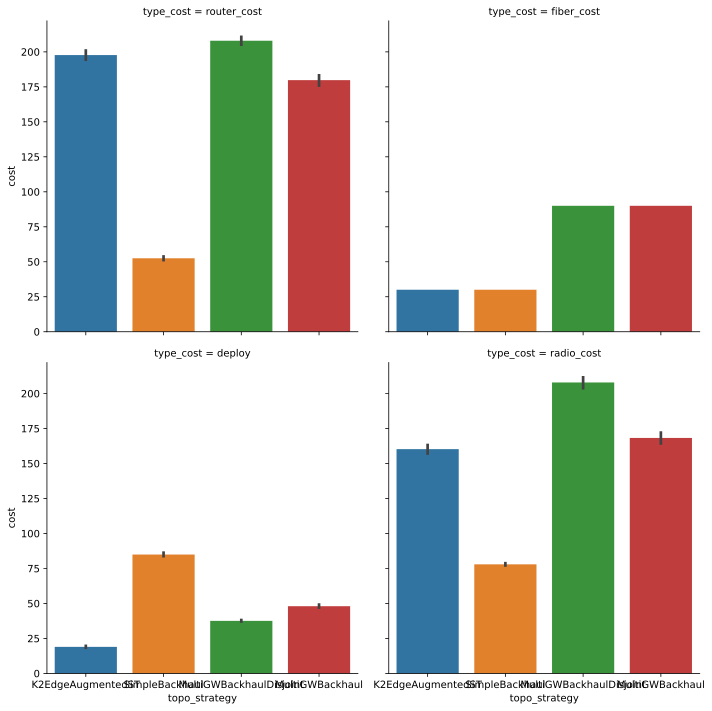

In [127]:
g = sns.catplot(data=edf[(edf.topo_strategy != 'VisGraphMultiGW') & (edf.topo_strategy != 'VisGraph')], 
            col='type_cost', 
            x='topo_strategy',
            y='cost', 
            kind="bar", 
            col_wrap=2)